### Name : Ashutosh Kumar
### Email: ashutoshind2017@outlook.com  


# Problem Statement Description :

#### USECASE 1: 
   
•	Create RFMB segments while maintaining industry standards to segment the clusters based on Recency, Frequency and Monetary attributes.  
•	The solution(class, function)  that is going to be developed should take start date. End date, recency, frequency, Monetary as parameters.  
•	Please ensure the segments in the below mentioned rules.  
WHEN ‘111’ THEN ‘Champions’   
WHEN ‘113’ THEN ‘Promising’   
WHEN ‘114’ THEN ‘Potential Loyalist’     
WHEN ‘144’ THEN ‘New Customers’   
WHEN ‘312’ THEN ‘Loyal Customers’  
WHEN ‘442’ THEN ‘Cant loose them’    
WHEN ‘443’ THEN ‘Need Attention’  
WHEN ‘552’ THEN ‘About to Sleep’   
WHEN ‘553’ THEN ‘Hibernating’  
WHEN ‘554’ THEN ‘At Risk’     
WHEN ‘555’ THEN ‘Lost’.    
     
#### USECASE 2:  
   
•	Create CLTV for the existing customers in the dataset mentioned.  
•	Please ensure standard selecting criteria for the model to converge.  
•	The solution which could be either class or function need to take start date and end date in to consideration.  

## Step1 : EDA and Data Preparation




### Data Understanding and Data Pre-processing 

In [1]:
# Importing the required python libraries and packages :

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import time
import datetime as datetime

# Set notebook display options :
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

from sklearn.preprocessing import MinMaxScaler

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Data Issue 1 : There are "unnamed" columns found with blank data, so need to be removed as its unuseful.

In [3]:
# Reading the Order data from the CSV file: 

# find the columns that have 'unnamed', then drop those columns. 
orders_df = pd.read_csv(r'data\orders_data.csv')
orders_df.drop(orders_df.columns[orders_df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

orders_df.head()

,order_number,total,status,customer_account_id,tenant_id,store_id,submitted_date,fulfillment_date
0,336121,NaN,Accepted,54660.0,TNG00072,STIN000000110,6/7/2019,4/18/2019
1,338138,NaN,Accepted,17768.0,TNG00072,STIN000000110,6/4/2020,3/14/2019
2,338638,NaN,Accepted,17316.0,TNG00072,STIN000000110,12/16/2020,4/11/2016
3,338027,NaN,Accepted,3431.0,TNG00072,STIN000000110,1/4/2020,8/18/2019
4,338559,NaN,Accepted,52850.0,TNG00072,STIN000000110,10/24/2019,9/5/2020


In [4]:
# Read the product data from CSV file  :
items_df = pd.read_csv(r'data\items_data.csv')
items_df.head()

,product_code,order_number,quantity
0,115280,331,1
1,membership_product,196,1
2,542131,708,1
3,229161,356,1
4,360242,394,1


In [5]:
# Function to get the information about the dataframe :

def check_df(dataframe):
    print("################ Shape ####################")
    print(dataframe.shape)
    print("############### Columns ###################")
    print(dataframe.columns)
    print("############### Types #####################")
    print(dataframe.dtypes)
    print("############### Describe ###################")
    print(dataframe.describe().T)
    print("############### Info ###################")
    print(dataframe.info())

In [6]:
# Information about the item data : 
check_df(items_df)

################ Shape ####################
(54480, 3)
############### Columns ###################
Index(['product_code', 'order_number', 'quantity'], dtype='object')
############### Types #####################
product_code    object
order_number     int64
quantity         int64
dtype: object
############### Describe ###################
                count          mean           std  min      25%      50%  \
order_number  54480.0  43368.628634  41743.356341  1.0  10542.0  33548.0   
quantity      54480.0      1.546751      6.781013  1.0      1.0      1.0   

                   75%        max  
order_number  79015.25  2242922.0  
quantity          1.00     1000.0  
############### Info ###################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54480 entries, 0 to 54479
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_code  54360 non-null  object
 1   order_number  54480 non-null  int64 
 2   qu

In [7]:
# Information about the item data : 
check_df(orders_df)

################ Shape ####################
(470571, 8)
############### Columns ###################
Index(['order_number', 'total', 'status', 'customer_account_id', 'tenant_id',
       'store_id', 'submitted_date', 'fulfillment_date'],
      dtype='object')
############### Types #####################
order_number             int64
total                  float64
status                  object
customer_account_id    float64
tenant_id               object
store_id                object
submitted_date          object
fulfillment_date        object
dtype: object
############### Describe ###################
                        count           mean            std   min       25%  \
order_number         470571.0  330619.499903  373505.605467  1.00  94844.00   
total                 45911.0      71.852421      92.189648  0.53     19.97   
customer_account_id  435689.0   29612.454650   17239.900927  1.00  14833.00   

                           50%        75%        max  
order_number       

### Missing value analysis:

In [8]:
# Let's visualise the missing values:

def missing_values_plot(df):
    missing_data_df = (df.isnull().sum() / len(df)) * 100
    missing_data_df = missing_data_df.drop(missing_data_df[missing_data_df == 0].index).sort_values(ascending=False)

    plt.figure(figsize=(3, 5))
    plt.xticks(rotation="90")
    plt.title('Missing Data Analysis Plot')
    plt.xlabel("Column name")
    plt.ylabel("Missing value percentages")
    sns.barplot(x=missing_data_df.index, y=missing_data_df)
    plt.show()

In [9]:
# Identify the missing data:
# creating a function to identify the missing data in dataset:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [10]:
missing_data(items_df)

,Total,Percent
product_code,120,0.220264
quantity,0,0.000000
order_number,0,0.000000


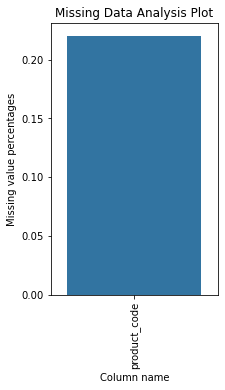

In [11]:
missing_values_plot(items_df)

In [12]:
# Around 22% of data is missing for the product code in items data.

In [13]:
missing_data(orders_df)

,Total,Percent
total,424660,90.243555
submitted_date,38983,8.284191
customer_account_id,34882,7.412696
fulfillment_date,2204,0.468367
store_id,0,0.000000
tenant_id,0,0.000000
status,0,0.000000
order_number,0,0.000000


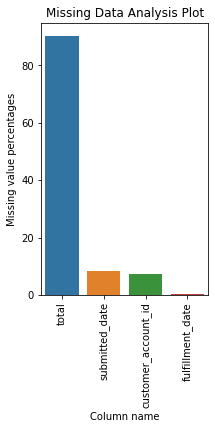

In [14]:
missing_values_plot(orders_df)

In [15]:
# Around 90% of data is missing for the "total", close to 8 % of data is missing for submitted data and customer_account_id
# Around 0.5 % of fulfilment date is missing

In [16]:
# Let's plot the number of status of orders :
orders_df['status'].value_counts()

Accepted         422678
Abandoned         28503
Pending            8226
Errored            4862
Completed          4736
Cancelled          1364
Processing          194
PendingReview         5
Null                  2
Validated             1
Name: status, dtype: int64

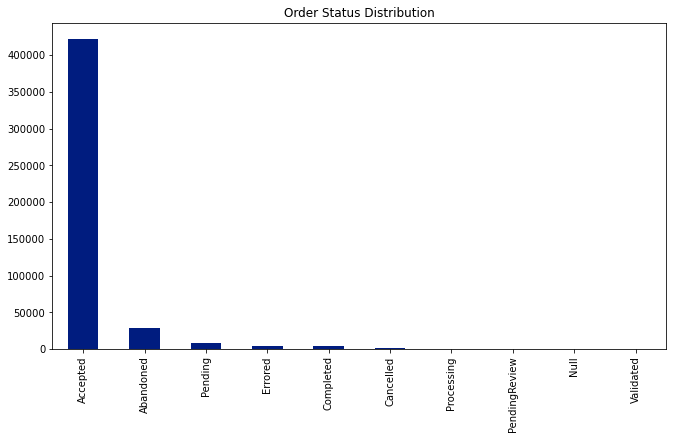

In [17]:
# Order Status Distribution :
plt.figure(figsize=(11,6))

plt.style.use('seaborn-dark-palette')
orders_df['status'].value_counts().plot(kind="bar")
plt.title("Order Status Distribution")

plt.show()

In [18]:
# So, the highest numbers of orders are Accepted : 4,00,000 approx and least number of orders are Validated orders.

### Outlier Data Analysis and Treatment:

[Text(0.5, 1.0, 'Distribution of TransactionAmount')]

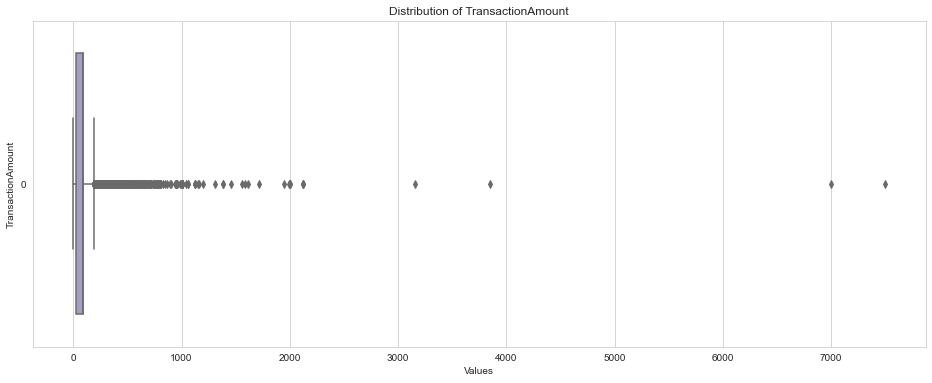

In [19]:
# Let's try to visualise the distribution of the Order transction amount :

sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(16,6))
# Using log scale:
#ax.set_xscale("log")
ax = sns.boxplot(data=orders_df['total'] , orient="h", palette="Purples")
# Using the custom ticker :
#ax.xaxis.set_major_locator(ticker.MultipleLocator(200000))
ax.set(ylabel="TransactionAmount")
ax.set(xlabel="Values")
ax.set(title="Distribution of TransactionAmount")
#sns.despine(trim=True,left=True)

[Text(0.5, 1.0, 'Distribution of Transaction Quantity')]

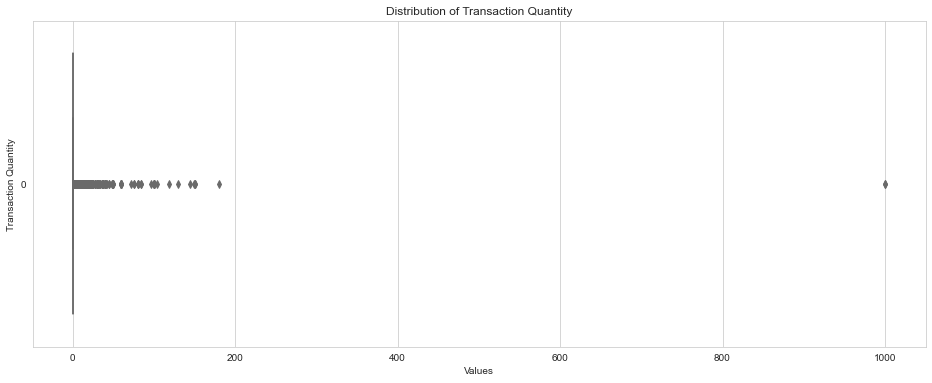

In [20]:
# Let's try to visualise the distribution of the Order item quantity :

sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(16,6))
# Using log scale:
#ax.set_xscale("log")
ax = sns.boxplot(data=items_df['quantity'] , orient="h", palette="Purples")
# Using the custom ticker :
#ax.xaxis.set_major_locator(ticker.MultipleLocator(200000))
ax.set(ylabel="Transaction Quantity")
ax.set(xlabel="Values")
ax.set(title="Distribution of Transaction Quantity")
#sns.despine(trim=True,left=True)

In [21]:
# We can clearly see there are statistical outliers for both Order Amount and Transaction Quantities.

In [22]:
# to define and outlier threshold:
def outlier_thresholds(dataframe, variable):
    Q1=dataframe[variable].quantile(0.01)
    Q3=dataframe[variable].quantile(0.99)
    interquartile_range= Q3 - Q1
    up_limit = Q3 + 1.5 * interquartile_range
    low_limit = Q1 - 1.5 * interquartile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] > up_limit), variable]=up_limit

In [23]:
# Treatment of outliers :
replace_with_thresholds(items_df, "quantity")
replace_with_thresholds(orders_df, "total")

### Data Cleaning :

In [24]:
# Doing join to update the item information with the order information :

In [25]:
print(f"missing number of observations:/n {orders_df.isnull().sum()}") 

missing number of observations:/n order_number                0
total                  424660
status                      0
customer_account_id     34882
tenant_id                   0
store_id                    0
submitted_date          38983
fulfillment_date         2204
dtype: int64


In [26]:
# Drop Null observations :
orders_df.dropna(inplace=True)
orders_df.isnull().sum()
print("dropped observations")
print(f"number of unique observations:/n {orders_df.nunique()}")

dropped observations
number of unique observations:/n order_number           11112
total                   2997
status                     9
customer_account_id     9631
tenant_id                  2
store_id                   2
submitted_date           248
fulfillment_date         248
dtype: int64


In [27]:
# Convert dates columns into datetime datatype:
orders_df['submitted_date'] = orders_df['submitted_date'].astype('datetime64[ns]')
orders_df['fulfillment_date'] = orders_df['fulfillment_date'].astype('datetime64[ns]')

# convert the customer acocunt id and order quantity to integer datatype :
orders_df['customer_account_id'] = orders_df['customer_account_id'].astype('int')
items_df['quantity'] = items_df['quantity'].astype('int')

In [28]:
from datetime import datetime

# Take order for order submission and fulfilment dates lessthan equal current date:
orders_df=orders_df[(orders_df["submitted_date"]<=datetime.now())]
orders_df=orders_df[(orders_df["fulfillment_date"]<=datetime.now())]

In [29]:
# Drop orders with incorrect status :
orders_df=orders_df[~orders_df['status'].isin(['Abandoned', 'Pending', 'Errored', 'Cancelled', 'Null'])]
print("Abandoned, Pending, Errored, Cancelled, Null i.e. Invalid orders dropped")

Abandoned, Pending, Errored, Cancelled, Null i.e. Invalid orders dropped


In [30]:
orders_df.tail()

,order_number,total,status,customer_account_id,tenant_id,store_id,submitted_date,fulfillment_date
470498,98650,14.72,Completed,14558,TNB00084,STOM000000123,2021-11-19,2021-11-19
470539,99484,9.98,Accepted,25180,TNB00084,STOM000000123,2021-11-20,2021-11-20
470541,99497,105.89,Accepted,29879,TNB00084,STOM000000123,2021-11-20,2021-11-20
470568,86098,47.64,Completed,5336,TNB00084,STOM000000123,2021-02-04,2021-11-07
470570,24530,13.98,Accepted,5336,TNB00084,STOM000000123,2021-02-04,2021-09-05


## Step2 : Customer Segmentation with RFM Analysis :  
  
The RFM model is a customer segmentation technique. RFM stands for Recency, Frequency, and Monetary value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer's behavior because frequency and monetary value affects a customer's lifetime value, and recency affects retention, a measure of engagement.

## Prepare the data for modelling
1. R (Recency): Number of days since last purchase
2. F (Frequency): Number of tracsactions
3. M (Monetary): Total amount of transactions (revenue contributed)

In [31]:
# Create RFM dataframe for each customer:
rfm = orders_df.groupby('customer_account_id').agg({'submitted_date': lambda date: (datetime.now() - date.max()).days,
                                            'order_number': lambda invc: invc.nunique(),
                                            'total': lambda price: price.sum()})
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()

,Recency,Frequency,Monetary
customer_account_id,,,
1000,335,5,1212.08
1001,335,20,524.62
1002,349,6,48.37
1003,447,1,1.97
1004,447,1,1.97


In [32]:
# Remove the customer who has no contribution to monetary profit :
rfm=rfm[(rfm["Monetary"]>0)]

In [33]:
#RFM Scores
rfm["Recency_score"] = pd.qcut(rfm["Recency"], 5, labels=[1, 2, 3, 4, 5])
rfm["Frequency_score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[5, 4, 3, 2, 1])
rfm["Monetary_score"] = pd.qcut(rfm["Monetary"], 5, labels=[5, 4, 3, 2, 1])
rfm["RFM_SCORE"] = rfm["Recency_score"].astype(str) + rfm["Frequency_score"].astype(str)+ rfm["Monetary_score"].astype(str)
rfm.head()

,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score,RFM_SCORE
customer_account_id,,,,,,,
1000,335,5,1212.08,5,1,1,511
1001,335,20,524.62,5,1,1,511
1002,349,6,48.37,5,1,3,513
1003,447,1,1.97,5,5,5,555
1004,447,1,1.97,5,5,5,555


In [34]:
seg_map = {
            r'111': 'Champions',
            r'113': 'Promising',
            r'114': 'Potential Loyalist',
            r'144': 'New Customers',
            r'312': 'Loyal Customers',
            r'442': 'Can not loose them',
            r'443': 'Need Attention',
            r'552': 'About to Sleep',
            r'553': 'Hibernating',
            r'554': 'At Risk',
            r'555': 'Lost'
        }

seg_map2 = {
        r'[1-5][1-5][1-5]': 'Others_Segment',
         }


rfm["RFM_Segment"] = rfm["RFM_SCORE"].replace(seg_map, regex=True)
rfm["RFM_Segment"] = rfm["RFM_Segment"].replace(seg_map2, regex=True)
rfm.reset_index()
rfm.tail()

,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score,RFM_SCORE,RFM_Segment
customer_account_id,,,,,,,,
29855,88,1,89.99,1,1,2,112,Others_Segment
29861,88,1,54.99,1,1,3,113,Promising
29863,88,1,86.21,1,1,2,112,Others_Segment
29877,88,1,23.08,1,1,4,114,Potential Loyalist
29879,88,1,105.89,1,1,2,112,Others_Segment


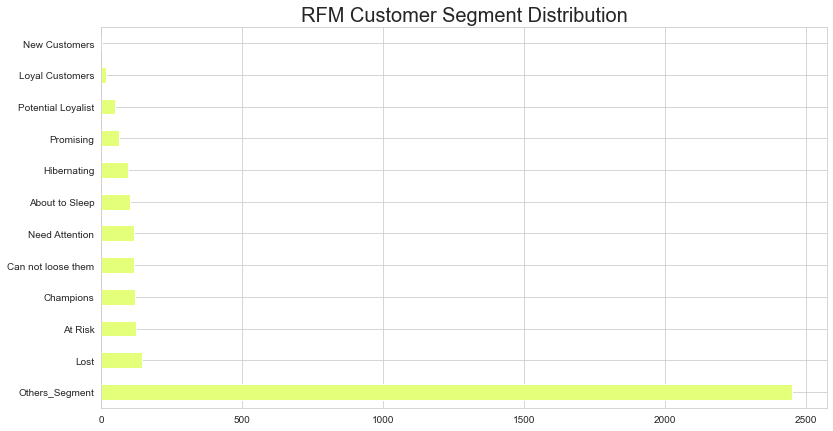

In [35]:
# Visualise the customer segments :
plt.figure(figsize=(13,7))

plt.style.use('seaborn-dark-palette')
rfm['RFM_Segment'].value_counts().plot(kind="barh", colormap='Wistia')
plt.title("RFM Customer Segment Distribution", size=20)
plt.show()

## Step3: CRM analytics using CLTV for the customers :    
  
Customer lifetime value (CLV), a term sometimes used interchangeably with customer lifetime value, is the prediction of a company's net profit contributed to its overall future relationship with a customer.    
Firms use many techniques and methods to make these critical decisions. Customer lifetime value (also called CLV or CLTV ) is one of the technique which is rapidly gaining acceptance as a metric to acquire, grow, and retain the “right” customers in customer relationship management (CRM).  y
Lifetime value is a critical metric because it represents the maximum amount that customers may be expected to spend in order to acquire new ones. As a result, it's crucial in determining the payback of marketing expenses used in marketing mix modeling.

## Formula for CLTV calculation:    
   
### CLTV = ( (Customer_Value(CV) )/Churn_Rate) x Profit_margin  
 
Customer_Value(CV) = Average_Order_Value * Purchase_Frequency,  
Average_Order_Value = Total_Revenue / Total_Number_of_Orders,   
Purchase_Frequency = Total_Number_of_Orders / Total_Number_of_Customers,  
Churn_Rate= 1-Repeat Rate,  
Repeat Rate = the ratio of the number of customers with more than one order to the number of unique customers
  

In [36]:
# Merge item and orders dataframes:
item_orders_df = pd.merge(orders_df, items_df, how = 'left', on = "order_number")
item_orders_df.head()

,order_number,total,status,customer_account_id,tenant_id,store_id,submitted_date,fulfillment_date,product_code,quantity
0,22,1.23,Completed,1001,TNT00076,STOM000000114,2020-11-04,2020-11-04,123456,1.0
1,298,3.98,Accepted,1059,TNT00076,STOM000000114,2021-02-18,2021-02-18,11192550693,2.0
2,481,299.98,Processing,1000,TNT00076,STOM000000114,2021-03-18,2021-03-18,805100,1.0
3,481,299.98,Processing,1000,TNT00076,STOM000000114,2021-03-18,2021-03-18,777988,2.0
4,666,5.17,Completed,1037,TNT00076,STOM000000114,2021-04-29,2021-04-29,211203,1.0


In [37]:
# Let's create a dataframe for CLTV:
cltv_df = item_orders_df.groupby('customer_account_id').agg({'submitted_date': lambda date: (date.max() - date.min()).days,
                                        'order_number': lambda num: num.nunique(),
                                        'quantity': lambda quant: quant.sum(),
                                        'total': lambda price: price.sum()})
cltv_df.head()

,submitted_date,order_number,quantity,total
customer_account_id,,,,
1000,146,5,23.0,2349.31
1001,146,20,48.0,865.15
1002,125,6,23.0,78.22
1003,0,1,1.0,1.97
1004,0,1,1.0,1.97


In [38]:
# total transaction, total unit, total price
cltv_df.columns=['num_days','num_transactions','num_units','spent_money']

### 3.1 Calculate Average Order Value :

In [39]:
cltv_df['avg_order_value']=cltv_df['spent_money']/cltv_df['num_transactions']

In [40]:
cltv_df.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value
customer_account_id,,,,,
1000,146,5,23.0,2349.31,469.862000
1001,146,20,48.0,865.15,43.257500
1002,125,6,23.0,78.22,13.036667
1003,0,1,1.0,1.97,1.970000
1004,0,1,1.0,1.97,1.970000


### 3.2 Calculate Purchase Frequency :

In [41]:
purchase_frequency=sum(cltv_df['num_transactions'])/cltv_df.shape[0]

### 3.3 Calculate Repeat Rate and Churn Rate :

In [42]:
# Repeat Rate
repeat_rate=cltv_df[cltv_df.num_transactions > 1].shape[0]/cltv_df.shape[0]

In [43]:
#Churn Rate
churn_rate=1-repeat_rate

In [44]:
purchase_frequency,repeat_rate,churn_rate

(1.3391176470588235, 0.1564705882352941, 0.8435294117647059)

### 3.4 Calculate Profit Margin:

In [45]:
# Let's assume that the business has 5 % profit on total sale:
cltv_df['profit_margin']=cltv_df['spent_money']*0.05

In [46]:
cltv_df.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin
customer_account_id,,,,,,
1000,146,5,23.0,2349.31,469.862000,117.4655
1001,146,20,48.0,865.15,43.257500,43.2575
1002,125,6,23.0,78.22,13.036667,3.9110
1003,0,1,1.0,1.97,1.970000,0.0985
1004,0,1,1.0,1.97,1.970000,0.0985


### 3.5 Calculate Customer Lifetime Value:

In [47]:
# Customer Value
cltv_df['CLV']=(cltv_df['avg_order_value']*purchase_frequency)/churn_rate

#Customer Lifetime Value
cltv_df['cust_lifetime_value']=cltv_df['CLV']*cltv_df['profit_margin']

In [48]:
cltv_df.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin,CLV,cust_lifetime_value
customer_account_id,,,,,,,,
1000,146,5,23.0,2349.31,469.862000,117.4655,745.914116,87619.174647
1001,146,20,48.0,865.15,43.257500,43.2575,68.672035,2970.580571
1002,125,6,23.0,78.22,13.036667,3.9110,20.695936,80.941804
1003,0,1,1.0,1.97,1.970000,0.0985,3.127409,0.308050
1004,0,1,1.0,1.97,1.970000,0.0985,3.127409,0.308050


### 3.6 Segment customers based on CLTV value :  
Segment are useful in making better customer personalizations

In [49]:
cltv_df["Segment"] = pd.qcut(cltv_df["cust_lifetime_value"], 5, labels = ["E", "D", "C", "B", "A"])

In [50]:
cltv_df.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin,CLV,cust_lifetime_value,Segment
customer_account_id,,,,,,,,,
1000,146,5,23.0,2349.31,469.862000,117.4655,745.914116,87619.174647,A
1001,146,20,48.0,865.15,43.257500,43.2575,68.672035,2970.580571,B
1002,125,6,23.0,78.22,13.036667,3.9110,20.695936,80.941804,D
1003,0,1,1.0,1.97,1.970000,0.0985,3.127409,0.308050,E
1004,0,1,1.0,1.97,1.970000,0.0985,3.127409,0.308050,E


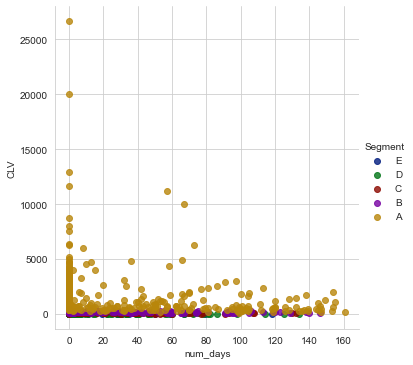

In [51]:
sns.lmplot(x='num_days', y='CLV', data=cltv_df, hue='Segment', fit_reg=False)

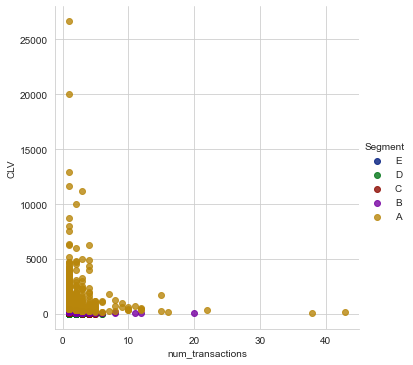

In [52]:
sns.lmplot(x='num_transactions', y='CLV', data=cltv_df, hue='Segment', fit_reg=False)

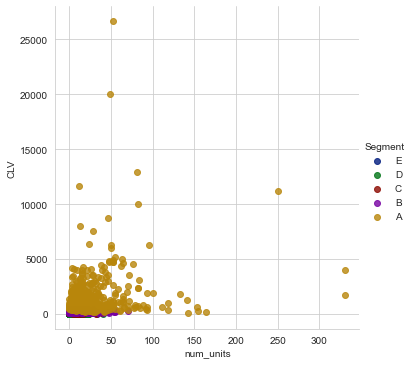

In [53]:
sns.lmplot(x='num_units', y='CLV', data=cltv_df, hue='Segment', fit_reg=False)

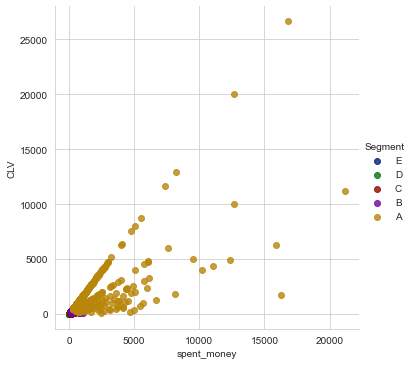

In [54]:
sns.lmplot(x='spent_money', y='CLV', data=cltv_df, hue='Segment', fit_reg=False)

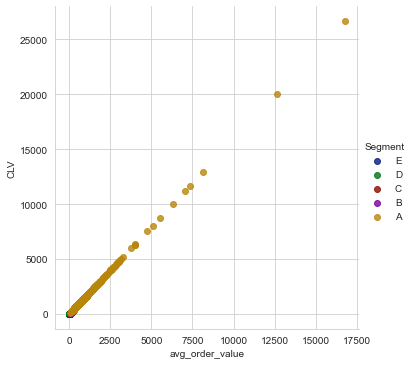

In [55]:

sns.lmplot(x='avg_order_value', y='CLV', data=cltv_df, hue='Segment', fit_reg=False)

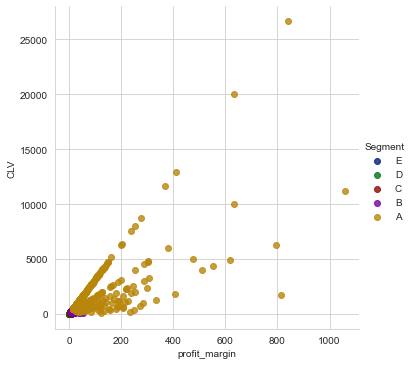

In [56]:
sns.lmplot(x='profit_margin', y='CLV', data=cltv_df, hue='Segment', fit_reg=False)

<AxesSubplot:xlabel='Segment', ylabel='num_transactions'>

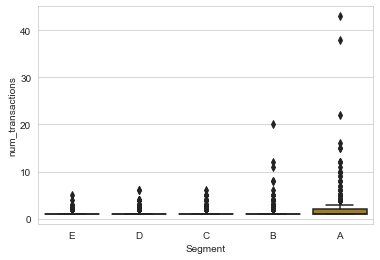

In [57]:
# plot
sns.boxplot(x='Segment', y='num_transactions', data=cltv_df)

<AxesSubplot:xlabel='Segment', ylabel='spent_money'>

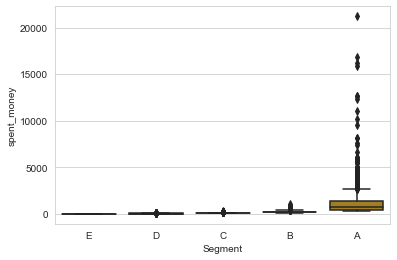

In [58]:
# plot
sns.boxplot(x='Segment', y='spent_money', data=cltv_df)

<AxesSubplot:xlabel='Segment', ylabel='num_units'>

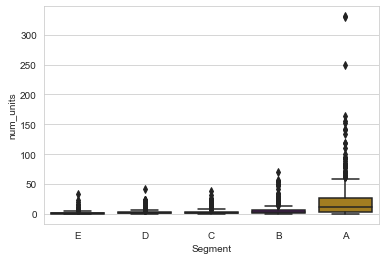

In [59]:
# plot
sns.boxplot(x='Segment', y='num_units', data=cltv_df)

In [60]:
# Total transaction, total unit, total price, CLTV and SCALED CLTV values are interpreted with their count, sum, and mean values
cltv_df.groupby("Segment")[["num_transactions", "num_units", "spent_money", "cust_lifetime_value", "CLV"]].agg(
    {"count", "mean", "sum"})

num_transactions                 num_units                   \
                     sum count      mean       sum count       mean   
Segment                                                               
E                    726   680  1.067647    1052.0   680   1.547059   
D                    796   680  1.170588    1929.0   680   2.836765   
C                    814   680  1.197059    2471.0   680   3.633824   
B                    906   680  1.332353    3987.0   680   5.863235   
A                   1311   680  1.927941   14260.0   680  20.970588   

        spent_money                    cust_lifetime_value        \
                sum count         mean                 sum count   
Segment                                                            
E           7470.62   680    10.986206        9.784270e+03   680   
D          31439.95   680    46.235221        1.071037e+05   680   
C          65869.95   680    96.867574        4.545386e+05   680   
B         151942.63   680   223.445044        2.300473e+06   680   
A         914959.37   680  1345.528485        1.496265e+08   680   

                                  CLV                     
                  mean            sum count         mean  
Segment                                                   
E            14.388632   11267.747890   680    16.570217  
D           157.505462   44749.436199   680    65.807994  
C           668.439106   92868.883511   680   136.571888  
B          3383.048274  201094.799337   680   295.727646  
A        220039.036658  916699.841133   680  1348.088002

In [61]:
############################################### End of Assignment ##################################################